# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


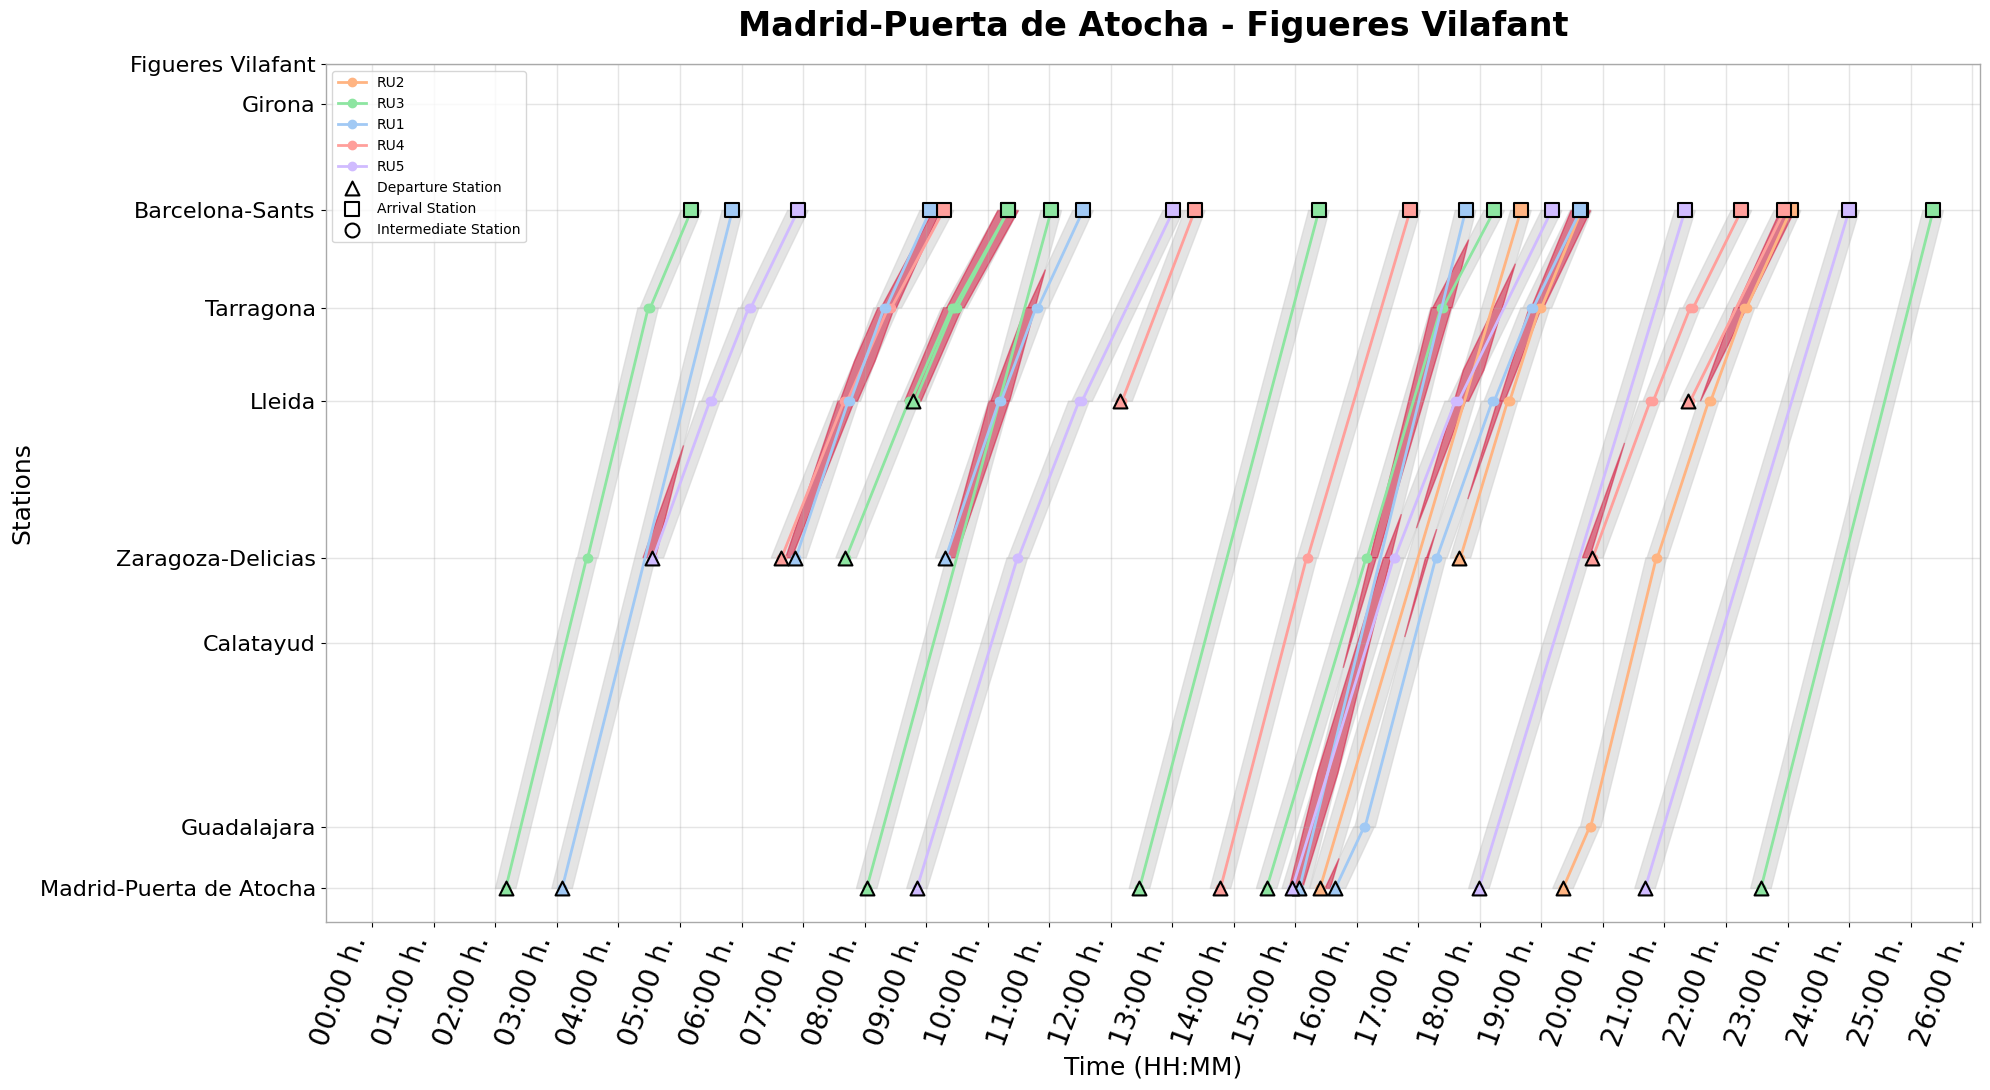

In [6]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/mealpy/'
)

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT



In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {
    "Genetic Algorithm": GA.BaseGA,
    "Particle Swarm Optimization": PSO.OriginalPSO,
    "Simulated Annealing": SA.OriginalSA,
    "Differential Evolution": DE.OriginalDE,
    "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
    "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
    "Artificial Bee Colony": ABC.OriginalABC,
    "Grey Wolf Optimizer": GWO.OriginalGWO,
    "Whale Optimization Algorithm": WOA.OriginalWOA,
    "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA
}

reports_path = Path('../reports/sensitivity_analysis/')

In [9]:
import itertools

from IPython.display import clear_output

from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

seed_initializer = 29

safety_headways = (2.5, 5, 10)
im_boundaries = (30, 45, 60)

for safety_headway, im_bound in itertools.product(safety_headways, im_boundaries):
    mptt = MPTT(
        requested_schedule=requested_schedule,
        revenue_behavior=revenue_behaviour,
        line=line,
        safe_headway=safety_headway,
        im_mod_margin=im_bound
    )

    # 0. Problem formulation
    lb, ub = zip(*mptt.boundaries.real)

    problem = {"obj_func": mptt.objective_function,
               "bounds": IntegerVar(lb=lb,
                                  ub=ub),
               "minmax": "max",
               "save_population": True}

    # 1. Iter algorithms
    df_history = pd.DataFrame()
    df_population = pd.DataFrame()

    for algo_name, algo in mp_algos.items():

        # Re-initialize seed
        np.random.seed(seed_initializer)

        print(f"Running {algo_name}")
        for r in range(1, runs+1):
            print("\tRun: ", r)

            run_seed = np.random.randint(0, 1000)

            # Run algorithm
            if algo_name == "Simulated Annealing":
                optimizer = algo(epoch=epochs*pop_size)
                optimizer.solve(problem, seed=run_seed)
            else:
                optimizer = algo(epoch=epochs, pop_size=pop_size)
                optimizer.solve(problem, seed=run_seed)

            # Build run history dataframe
            columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real',
                       'Diversity', 'Exploitation', 'Exploration']
            run_history = pd.DataFrame(columns=columns)

            # Save optimizer history to dataframe
            for i, data in enumerate(optimizer.history.list_global_best):
                mptt.update_schedule(data.solution)
                run_history.loc[i] = [algo_name,
                                      i,
                                      data.target.fitness,
                                      optimizer.history.list_epoch_time[i],
                                      mptt.get_heuristic_schedule_old(),
                                      data.solution,
                                      optimizer.history.list_diversity[i],
                                      optimizer.history.list_exploitation[i],
                                      optimizer.history.list_exploration[i]]

            run_history.insert(0, "Run", r)
            df_history = pd.concat([df_history, run_history], axis=0)

            # Population dataframe
            if algo_name == "Simulated Annealing":
                continue

            population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
            population_colums.insert(0, 'Iteration')
            run_population = pd.DataFrame(columns=population_colums)

            for i, pop_epoch in enumerate(optimizer.history.list_population):
                population_row = [i]
                real = []
                discrete = []
                for individual in pop_epoch:
                    mptt.update_schedule(individual.solution)
                    real.append(individual.solution)
                    discrete.append(mptt.get_heuristic_schedule_old())

                population_row = [i, *real, *discrete]
                run_population.loc[len(run_population)] = population_row

            run_population.insert(0, "Run", r)
            run_population.insert(1, "Algo", algo_name)
            df_population = pd.concat([df_population, run_population], axis=0)

    df_history.to_csv(reports_path / f'df_history_sh_{safety_headway}_im_{im_bound}.csv', sep=";", index=False)
    df_population.to_csv(reports_path / f'df_population_sh_{safety_headway}_im_{im_bound}.csv', sep=";", index=False)
    clear_output()

## 2. Results analysis

In [10]:
import glob

reports_path = "../reports/sensitivity_analysis/*.csv"
file_names = glob.glob(reports_path)
print(len(file_names))

18


In [11]:
import pandas as pd
from pathlib import Path

global_df_history = pd.DataFrame()
global_df_population = pd.DataFrame()

for file_name in file_names:
    print(f"Reading: {file_name}")
    # Extraer el valor de alpha del nombre del archivo
    safety_headway = float(Path(file_name).stem.split("_sh_")[1].split("_")[0])
    im_bound = float(Path(file_name).stem.split("_im_")[1].split(".")[0])
    print(safety_headway, im_bound)

    # Leer el dataframe correspondiente y añadir la columna "alpha"
    if 'history' in file_name:
        df_history = pd.read_csv(file_name, sep=";")
        df_history["safety_headway"] = safety_headway
        df_history["im_bound"] = im_bound
        global_df_history = pd.concat([global_df_history, df_history], ignore_index=True)
    elif 'population' in file_name:
        df_population = pd.read_csv(file_name, sep=";")
        df_population["safety_headway"] = safety_headway
        df_population["im_bound"] = im_bound
        global_df_population = pd.concat([global_df_population, df_population], ignore_index=True)


Reading: ../reports/sensitivity_analysis\df_history_sh_10_im_30.csv
10.0 30.0
Reading: ../reports/sensitivity_analysis\df_history_sh_10_im_45.csv
10.0 45.0
Reading: ../reports/sensitivity_analysis\df_history_sh_10_im_60.csv
10.0 60.0
Reading: ../reports/sensitivity_analysis\df_history_sh_2.5_im_30.csv
2.5 30.0
Reading: ../reports/sensitivity_analysis\df_history_sh_2.5_im_45.csv
2.5 45.0
Reading: ../reports/sensitivity_analysis\df_history_sh_2.5_im_60.csv
2.5 60.0
Reading: ../reports/sensitivity_analysis\df_history_sh_5_im_30.csv
5.0 30.0
Reading: ../reports/sensitivity_analysis\df_history_sh_5_im_45.csv
5.0 45.0
Reading: ../reports/sensitivity_analysis\df_history_sh_5_im_60.csv
5.0 60.0
Reading: ../reports/sensitivity_analysis\df_population_sh_10_im_30.csv
10.0 30.0
Reading: ../reports/sensitivity_analysis\df_population_sh_10_im_45.csv
10.0 45.0
Reading: ../reports/sensitivity_analysis\df_population_sh_10_im_60.csv
10.0 60.0
Reading: ../reports/sensitivity_analysis\df_population_sh_2.5

In [12]:
df_population = global_df_population
df_history = global_df_history

In [13]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,safety_headway,im_bound
0,1,Genetic Algorithm,0,2390.381417,0.203288,[ True False True False True True True Tr...,"[1059, 1114, 1147, 893, 978, 1047, 900, 840, 9...",6.686316,0.000000,100.000000,10.0,30.0
1,1,Genetic Algorithm,1,2390.381417,0.204655,[ True False True False True True True Tr...,"[1059, 1114, 1147, 893, 978, 1047, 900, 840, 9...",6.010526,10.107053,89.892947,10.0,30.0
2,1,Genetic Algorithm,2,2390.381417,0.202533,[ True False True False True True True Tr...,"[1059, 1114, 1147, 893, 978, 1047, 900, 840, 9...",5.775088,13.628254,86.371746,10.0,30.0
3,1,Genetic Algorithm,3,2657.182977,0.203605,[False False True True True True True Tr...,"[1059, 1114, 1144, 893, 970, 1047, 900, 826, 9...",5.431930,18.760495,81.239505,10.0,30.0
4,1,Genetic Algorithm,4,2934.130738,0.203501,[ True True False True True True False Fal...,"[1060, 1115, 1147, 874, 973, 1051, 900, 826, 9...",5.231228,21.762175,78.237825,10.0,30.0


In [14]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,safety_headway,im_bound
0,1,Genetic Algorithm,0,2390.381417,0.203288,"[True, False, True, False, True, True, True, T...","[1059, 1114, 1147, 893, 978, 1047, 900, 840, 9...",6.686316,0.000000,100.000000,10.0,30.0
1,1,Genetic Algorithm,1,2390.381417,0.204655,"[True, False, True, False, True, True, True, T...","[1059, 1114, 1147, 893, 978, 1047, 900, 840, 9...",6.010526,10.107053,89.892947,10.0,30.0
2,1,Genetic Algorithm,2,2390.381417,0.202533,"[True, False, True, False, True, True, True, T...","[1059, 1114, 1147, 893, 978, 1047, 900, 840, 9...",5.775088,13.628254,86.371746,10.0,30.0
3,1,Genetic Algorithm,3,2657.182977,0.203605,"[False, False, True, True, True, True, True, T...","[1059, 1114, 1144, 893, 970, 1047, 900, 826, 9...",5.431930,18.760495,81.239505,10.0,30.0
4,1,Genetic Algorithm,4,2934.130738,0.203501,"[True, True, False, True, True, True, False, F...","[1060, 1115, 1147, 874, 973, 1051, 900, 826, 9...",5.231228,21.762175,78.237825,10.0,30.0


In [15]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49,safety_headway,im_bound
0,1,Genetic Algorithm,0,"[1045.0, 1116.0, 1141.0, 872.0, 972.0, 1051.0,...","[1075.0, 1109.0, 1148.0, 850.0, 973.0, 1045.0,...","[1055.0, 1109.0, 1143.0, 892.0, 979.0, 1049.0,...","[1060.0, 1114.0, 1143.0, 873.0, 970.0, 1051.0,...","[1059.0, 1114.0, 1147.0, 851.0, 978.0, 1051.0,...","[1055.0, 1114.0, 1143.0, 893.0, 979.0, 1051.0,...","[1045.0, 1115.0, 1141.0, 867.0, 971.0, 1047.0,...",...,[False False True False True True False Tr...,[False False True False True True False Tr...,[False False True False True True False Fal...,[False False True True True True False Tr...,[False True False True True True False Tr...,[False False True False True True True Tr...,[False False True False True True False Tr...,[ True False True False True True True Tr...,10.0,30.0
1,1,Genetic Algorithm,1,"[1055.0, 1116.0, 1143.0, 872.0, 973.0, 1051.0,...","[1034.0, 1113.0, 1143.0, 892.0, 972.0, 1051.0,...","[1060.0, 1109.0, 1147.0, 873.0, 970.0, 1051.0,...","[1059.0, 1114.0, 1143.0, 893.0, 978.0, 1047.0,...","[1042.0, 1115.0, 1143.0, 873.0, 970.0, 1045.0,...","[1055.0, 1113.0, 1147.0, 855.0, 979.0, 1044.0,...","[1042.0, 1114.0, 1143.0, 873.0, 970.0, 1047.0,...",...,[ True False True False True False False Tr...,[False False True True True True False Tr...,[False False True True True True True Tr...,[False False True True True True False Tr...,[False False True False True True False Tr...,[False False True False True True True Tr...,[False False True True True True False Fal...,[False False True False True True True Tr...,10.0,30.0
2,1,Genetic Algorithm,2,"[1055.0, 1116.0, 1143.0, 872.0, 973.0, 1051.0,...","[1055.0, 1116.0, 1143.0, 872.0, 972.0, 1051.0,...","[1059.0, 1113.0, 1143.0, 892.0, 972.0, 1051.0,...","[1059.0, 1116.0, 1147.0, 872.0, 978.0, 1047.0,...","[1059.0, 1114.0, 1147.0, 851.0, 978.0, 1051.0,...","[1059.0, 1115.0, 1147.0, 893.0, 972.0, 1045.0,...","[1059.0, 1115.0, 1143.0, 873.0, 970.0, 1047.0,...",...,[False False True True True True False Fal...,[False True False True True True True Tr...,[False False False True True True False Fal...,[False True False True True True False Tr...,[False False True True True True False Tr...,[ True True False False True True False Fal...,[False True False True True True True Fal...,[False False True True True True True Tr...,10.0,30.0
3,1,Genetic Algorithm,3,"[1055.0, 1109.0, 1143.0, 872.0, 972.0, 1051.0,...","[1055.0, 1115.0, 1143.0, 872.0, 973.0, 1051.0,...","[1059.0, 1116.0, 1147.0, 893.0, 978.0, 1047.0,...","[1075.0, 1116.0, 1143.0, 873.0, 973.0, 1044.0,...","[1034.0, 1113.0, 1143.0, 890.0, 973.0, 1047.0,...","[1059.0, 1114.0, 1147.0, 873.0, 978.0, 1047.0,...","[1075.0, 1115.0, 1143.0, 872.0, 973.0, 1051.0,...",...,[False False True True True True True Tr...,[False False True False True True True Fal...,[ True False True True True True True Tr...,[False False True False True True True Tr...,[False True False True True True True Fal...,[ True False True True True True True Tr...,[ True False True True True True True Fal...,[False False False False True True True Tr...,10.0,30.0
4,1,Genetic Algorithm,4,"[1059.0, 1116.0, 1143.0, 873.0, 970.0, 1047.0,...","[1055.0, 1116.0, 1147.0, 893.0, 978.0, 1051.0,...","[1059.0, 1109.0, 1147.0, 872.0, 970.0, 1045.0,...","[1060.0, 1116.0, 1147.0, 873.0, 973.0, 1047.0,...","[1059.0, 1115.0, 1144.0, 872.0, 973.0, 1051.0,...","[1075.0, 1114.0, 1143.0, 893.0, 970.0, 1047.0,...","[1075.0, 1115.0, 1143.0, 872.0, 970.0, 1051.0,...",...,[False False True True True True True Tr...,[ True False True True True True True Tr...,[False True False True True True True Tr...,[False False False False True True True Fal...,[ True True False True True True False Fal...,[False True False True True True True Tr...,[ True True False True True True False Tr...,[False True False True True True True Tr...

In [39]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Genetic Algorithm', 'Particle Swarm Optimization', 'Ant Colony Optimization Continuous (ACOR)'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing new combination: Run = 1, Algo = Particle Swarm Optimization
Processing new combination: Run = 2, Algo = Particle Swarm Optimization
Processing new combination: Run = 3, Algo = Particle Swarm Optimization
Processing new combination: Run = 4, Algo = Particle Swarm Optimization
Processing new combination: Run = 5, Algo = Particle Swarm Optimization
Processing new combination: Run = 1, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 2, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 3, Algo = 

,Run,Algo,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,real_40,real_41,real_42,real_43,real_44,real_45,real_46,real_47,real_48,real_49
0,1,Genetic Algorithm,0,2031.274616,1238.495834,1454.067189,1708.999292,1567.878493,1363.951559,1205.755739,...,1948.765285,1652.308142,1676.024006,1266.957476,1788.940114,1596.962909,1436.649289,1594.477773,1210.28417,1479.103047
1,1,Genetic Algorithm,1,1513.822155,1589.064022,1676.857797,2004.254684,2051.601594,2032.051679,1989.344209,...,1694.746416,1868.030395,1525.331948,2102.729305,2007.498897,1585.386075,1489.380892,2294.927868,1337.848235,1205.755739
2,1,Genetic Algorithm,2,2574.487027,2189.309044,2382.830394,1668.250295,1953.326642,2148.220783,1730.720701,...,1525.331948,2332.021901,1881.442388,1568.197601,2266.160896,2172.970352,2508.743616,2459.141069,1795.164054,2264.969528
3,1,Genetic Algorithm,3,2375.365337,2524.283179,2535.26969,2294.927868,2089.175561,2678.906595,2126.069778,...,2428.805172,2113.841627,2063.691475,2926.528932,2298.234973,1967.041629,2051.00493,2046.372591,2062.046343,2006.82101
4,1,Genetic Algorithm,4,2453.410759,2373.076516,2504.878756,2682.496976,2624.696231,2403.293926,2579.238137,...,2114.839845,2372.867859,2937.469505,2705.032673,2269.372136,2428.818704,2146.880408,2435.213856,2168.901945,2778.377188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,Ant Colony Optimization Continuous (ACOR),95,3692.794172,3685.706292,3559.06688,3550.647771,3544.21025,3529.065126,3524.649683,...,3336.891378,3325.545799,3318.106678,3317.776329,3317.534158,3313.564225,3305.446377,3299.247901,3295.066858,3294.153695
1996,5,Ant Colony Optimization Continuous (ACOR),96,3692.794172,3685.706292,3559.06688,3550.647771,3544.21025,3529.065126,3524.649683,...,3347.176764,3343.484176,3336.891378,3325.545799,3318.106678,3317.776329,3317.534158,3313.564225,3305.446377,3299.247901
1997,5,Ant Colony Optimization Continuous (ACOR),97,3692.794172,3685.706292,3598.262559,3559.06688,3550.647771,3544.21025,3529.065126,...,3352.309698,3349.914224,3347.176764,3343.484176,3337.386799,3336.891378,3325.545799,3318.106678,3317.776329,3317.534158
1998,5,Ant Colony Optimization Continuous (ACOR),98,3692.794172,3685.706292,3598.262559,3559.06688,3550.647771,3544.21025,3529.065126,...,3353.63659,3353.209045,3352.309698,3349.914224,3347.176764,3343.484176,3337.386799,3336.891378,3325.545799,3318.106678


In [41]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_5_seed_fit_top3.csv', sep=";", index=False)

In [42]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Algorithm,Individual
0,1,0,2031.274616,Genetic Algorithm,ID_real_0
1,1,0,1238.495834,Genetic Algorithm,ID_real_1
2,1,0,1454.067189,Genetic Algorithm,ID_real_2
3,1,0,1708.999292,Genetic Algorithm,ID_real_3
4,1,0,1567.878493,Genetic Algorithm,ID_real_4
...,...,...,...,...,...
74995,5,99,3349.914224,Ant Colony Optimization Continuous (ACOR),ID_real_45
74996,5,99,3347.176764,Ant Colony Optimization Continuous (ACOR),ID_real_46
74997,5,99,3343.484176,Ant Colony Optimization Continuous (ACOR),ID_real_47
74998,5,99,3337.386799,Ant Colony Optimization Continuous (ACOR),ID_real_48


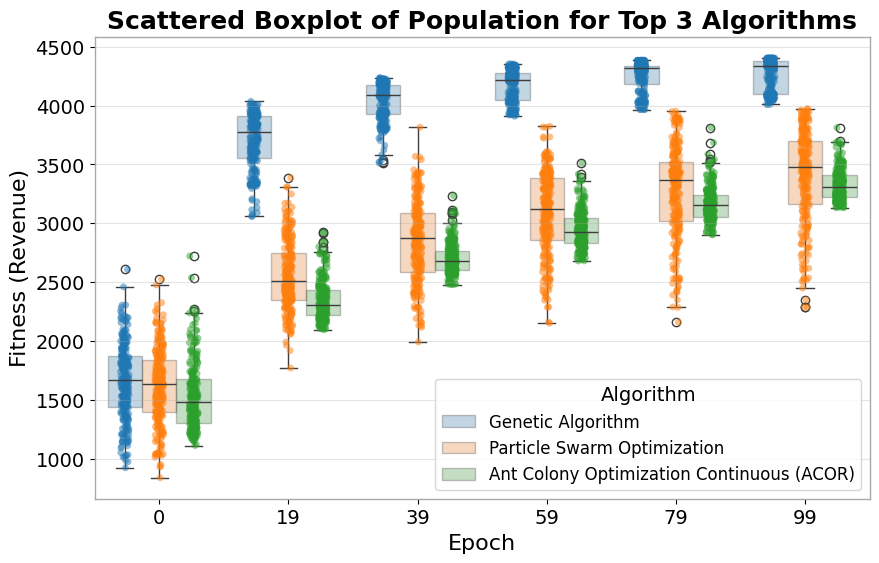

In [45]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [29]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behaviour:
    if revenue_behaviour[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behaviour[service]['ru']] = 1
    else:
        services_by_ru[revenue_behaviour[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: round(services_by_ru[ru] / n_services * 100, 2) for ru in services_by_ru}
print(frame_capacity)

{'RU2': 3, 'RU3': 7, 'RU1': 5, 'RU4': 5, 'RU5': 5}
{'RU2': 12.0, 'RU3': 28.0, 'RU1': 20.0, 'RU4': 20.0, 'RU5': 20.0}


In [30]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,safety_headway,im_bound
0,1,Genetic Algorithm,0,2502.910588,0.229565,"[False, True, False, True, True, True, True, F...","[1086, 1109, 1148, 858, 970, 1046, 898, 805, 9...",7.341053,0.000000,100.000000,10.0,30.0
1,1,Genetic Algorithm,1,2640.815661,0.280444,"[False, True, False, True, True, True, True, F...","[1060, 1109, 1140, 858, 975, 1049, 900, 827, 9...",6.463509,11.953924,88.046076,10.0,30.0
2,1,Genetic Algorithm,2,2730.387711,0.267000,"[False, True, False, True, True, False, True, ...","[1060, 1111, 1143, 858, 974, 1046, 900, 826, 9...",5.670526,22.755951,77.244049,10.0,30.0
3,1,Genetic Algorithm,3,2987.171566,0.258781,"[False, True, False, True, True, True, True, F...","[1062, 1109, 1140, 858, 974, 1049, 900, 826, 9...",5.079649,30.804894,69.195106,10.0,30.0
4,1,Genetic Algorithm,4,3329.851603,0.222542,"[False, True, False, True, True, True, True, F...","[1060, 1109, 1148, 847, 970, 1049, 886, 827, 9...",4.562105,37.854890,62.145110,10.0,30.0


In [33]:
import itertools
import numpy as np
import pandas as pd

# Se asume que df_history tiene la columna 'Alpha'
# Además, se asume que ru_names y frame_capacity ya están definidos
# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame (agregamos 'Alpha')
columns = ['Safety Headway', 'IM Bound', 'Algo', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
safety_headway_grouped_df = df_history.groupby('safety_headway')
for safety_key, safety_group in safety_headway_grouped_df:
    im_bound_grouped_df = safety_group.groupby('im_bound')
    for im_label, im_group in im_bound_grouped_df:
        alpha_grouped_df = im_group.groupby('Algo')
        for algo_label, algo_group in alpha_grouped_df:
            run = algo_group['Run'].iloc[-1]
            # Extraemos el valor de Alpha (suponiendo que es constante en cada run)
            fitness = np.round(algo_group['Fitness'].iloc[-1], 2)
            revenue = mptt.objective_function(algo_group['Real'].iloc[-1])
            execution_time = np.round(algo_group['ExecutionTime'].sum(), 2)
            scheduled_trains_array = algo_group['Discrete'].iloc[-1]
            scheduled_trains = int(sum(scheduled_trains_array))
            real_solution = algo_group['Real'].iloc[-1]

            # Actualizamos la planificación
            mptt.update_schedule(real_solution)

            # Obtener el diccionario de importancias (por RU)
            importance_dict = mptt.sum_importance(scheduled_trains_array)
            importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}
            total_importance = sum(importance_dict.values())

            # Calcular la suma de diferencias absolutas pairwise entre las importancias.
            pairwise_diff = 0
            for ru1, ru2 in itertools.combinations(ru_names, 2):
                pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

            # Se calcula max_ineq de acuerdo al número de RU (usado para normalizar la inequidad)
            if len(ru_names) % 2 == 0:
                max_ineq = (len(ru_names)**2) / 4
            else:
                max_ineq = (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

            # Construir la fila de datos
            row_data = [
                safety_key,
                im_label,
                algo_label,
                run,
                fitness,
                revenue,
                execution_time,
                scheduled_trains
            ]
            # Agregar, para cada RU, el valor de la importancia (en %)
            for ru in ru_names:
                row_data.append(round(importance_dict.get(ru, 0) * 100, 2))
            # Columna de Total Importance
            row_data.append(round(total_importance / len(ru_names) * 100, 2))
            # Columna de Inequity (normalizada)
            row_data.append(round(pairwise_diff / max_ineq * 100, 2))
            # Columna de Assigned capacity
            capacity_usage = 0.0
            for ru in ru_names:
                capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
            row_data.append(capacity_usage)

            summary_df.loc[len(summary_df)] = row_data

# Ordenamos o mostramos el DataFrame resumen si se desea
display(summary_df)

,Safety Headway,IM Bound,Algo,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,RU4,RU5,Total Importance,Inequity,Assigned capacity
0,2.5,30.0,Ant Colony Optimization Continuous (ACOR),5,4104.30,3960.109463,74.34,19,100.00,12.05,77.74,54.77,78.93,64.70,66.68,69.953304
1,2.5,30.0,Artificial Bee Colony,5,4069.09,3787.024803,250.78,19,60.69,12.05,88.38,88.33,100.00,69.89,67.86,75.994020
2,2.5,30.0,Covariance Matrix Adaptation Evolution Strategy,5,4280.49,3890.667940,218.68,18,38.61,12.05,77.74,100.00,100.00,65.68,79.09,70.935121
3,2.5,30.0,Differential Evolution,5,3883.12,3096.150806,123.12,21,94.54,12.05,100.00,54.77,100.00,72.27,73.71,79.309336
4,2.5,30.0,Genetic Algorithm,5,5284.29,4109.019398,125.27,23,66.14,64.15,100.00,100.00,100.00,86.06,35.19,88.926153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,10.0,60.0,Grey Wolf Optimizer,5,3261.35,3261.352881,130.20,16,77.92,12.05,60.90,48.14,74.15,54.63,52.58,58.540289
86,10.0,60.0,Hybrid Grey Wolf - Whale Optimization Algorithm,5,3262.03,3262.031293,129.76,16,38.61,12.05,60.75,100.00,78.93,58.07,72.07,61.962923
87,10.0,60.0,Particle Swarm Optimization,5,4265.40,4265.402318,131.83,17,72.46,12.05,77.74,48.14,100.00,62.08,68.50,67.334640
88,10.0,60.0,Simulated Annealing,5,2503.84,2503.838861,126.93,18,94.54,47.91,60.90,48.14,100.00,70.30,50.19,71.338121


In [16]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Sensitivity', 'Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

for comb_label, comb_group in df_history.groupby(['safety_headway', 'im_bound']):
    algo_grouped_df = comb_group.groupby('Algo')
    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        for group in run_grouped_df.groups:
            run = run_grouped_df.get_group(group)['Run'].iloc[-1]
            revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
            execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
            scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
            scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
            real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
            sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
            delta_dt = 0.0
            delta_tt = 0.0
            services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
            for i, service in enumerate(sm.requested_schedule):
                if not scheduled_trains_array[i]:
                    continue
                departure_station = list(sm.requested_schedule[service].keys())[0]
                delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                                sm.requested_schedule[service][departure_station][1])
                for j, stop in enumerate(sm.requested_schedule[service].keys()):
                    if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                        continue
                    delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

                service_tsp = service_tsps[service]
                services_by_tsp[service_tsp] += 1

            percentages_by_tsp = {}
            for tsp in services_by_tsp:
                percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
            row_data =  [comb_label, algo_group[0], run, revenue, execution_time,
                         scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
            summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,Sensitivity,Algorithm,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU4,RU5,RU2,RU3
21,"(2.5, 30.0)",Genetic Algorithm,2,5180.67,26.13,22,67.0,41.0,66.67 %,100.0 %,60.0 %,100.0 %,100.0 %
22,"(2.5, 30.0)",Genetic Algorithm,3,5180.23,25.34,22,46.0,40.0,66.67 %,100.0 %,80.0 %,80.0 %,100.0 %
24,"(2.5, 30.0)",Genetic Algorithm,5,4975.30,25.38,21,50.0,52.0,66.67 %,85.71 %,60.0 %,100.0 %,100.0 %
23,"(2.5, 30.0)",Genetic Algorithm,4,4910.22,25.30,21,52.0,60.0,33.33 %,100.0 %,60.0 %,100.0 %,100.0 %
70,"(2.5, 45.0)",Genetic Algorithm,1,4877.36,25.04,21,112.0,27.0,33.33 %,85.71 %,100.0 %,80.0 %,100.0 %
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,"(2.5, 60.0)",Simulated Annealing,2,1593.31,24.24,10,175.0,0.0,33.33 %,42.86 %,40.0 %,40.0 %,40.0 %
291,"(5.0, 60.0)",Simulated Annealing,2,1593.31,20.71,10,175.0,0.0,33.33 %,42.86 %,40.0 %,40.0 %,40.0 %
242,"(5.0, 45.0)",Simulated Annealing,3,1331.78,21.23,9,72.0,0.0,0.0 %,42.86 %,20.0 %,40.0 %,60.0 %
392,"(10.0, 45.0)",Simulated Annealing,3,1331.78,21.97,9,72.0,0.0,0.0 %,42.86 %,20.0 %,40.0 %,60.0 %


In [17]:
summary_df.head().to_latex()

'\\begin{tabular}{lllrrrrrrlllll}\n\\toprule\n & Sensitivity & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU5 & RU2 & RU3 \\\\\n\\midrule\n21 & (2.5, 30.0) & Genetic Algorithm & 2 & 5180.670000 & 26.130000 & 22 & 67.000000 & 41.000000 & 66.67 % & 100.0 % & 60.0 % & 100.0 % & 100.0 % \\\\\n22 & (2.5, 30.0) & Genetic Algorithm & 3 & 5180.230000 & 25.340000 & 22 & 46.000000 & 40.000000 & 66.67 % & 100.0 % & 80.0 % & 80.0 % & 100.0 % \\\\\n24 & (2.5, 30.0) & Genetic Algorithm & 5 & 4975.300000 & 25.380000 & 21 & 50.000000 & 52.000000 & 66.67 % & 85.71 % & 60.0 % & 100.0 % & 100.0 % \\\\\n23 & (2.5, 30.0) & Genetic Algorithm & 4 & 4910.220000 & 25.300000 & 21 & 52.000000 & 60.000000 & 33.33 % & 100.0 % & 60.0 % & 100.0 % & 100.0 % \\\\\n70 & (2.5, 45.0) & Genetic Algorithm & 1 & 4877.360000 & 25.040000 & 21 & 112.000000 & 27.000000 & 33.33 % & 85.71 % & 100.0 % & 80.0 % & 100.0 % \\\\\n\\bottomrule\n\\end{tabular}\n'

  safety infra       mean         std        p25       p50        p75   n
0    2.5  30.0  3183.9682  868.926065  2612.2800  3185.175  3624.0700  50
1    2.5  45.0  2976.2302  828.912982  2475.2550  2864.760  3470.2725  50
2    2.5  60.0  2889.8778  876.868909  2273.6750  2710.910  3536.2750  50
3    5.0  30.0  3139.6628  826.564527  2653.1775  3100.985  3604.6575  50
4    5.0  45.0  2952.7730  848.913676  2344.6300  2846.715  3671.6375  50
5    5.0  60.0  2864.6988  879.062101  2227.2100  2676.790  3520.9325  50
6   10.0  30.0  3041.6532  761.197473  2517.7025  2887.175  3538.2325  50
7   10.0  45.0  2860.6656  824.864211  2314.5575  2820.960  3428.5150  50
8   10.0  60.0  2776.9564  822.527538  2150.2250  2642.150  3415.1000  50


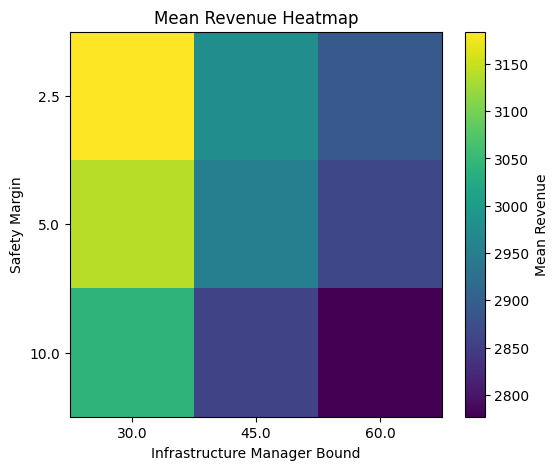


ANOVA 2-way con interacción:
                           sum_sq     df         F    PR(>F)
C(safety)           1.240763e+06    2.0  0.882894  0.414314
C(infra)            6.072824e+06    2.0  4.321258  0.013850
C(safety):C(infra)  1.416272e+04    4.0  0.005039  0.999949
Residual            3.098768e+08  441.0       NaN       NaN

Resumen del modelo:
                             OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.304
Date:                Wed, 04 Jun 2025   Prob (F-statistic):              0.240
Time:                        20:17:24   Log-Likelihood:                -3663.1
No. Observations:                 450   AIC:                             7344.
Df Residuals:                     441   BIC:                             7381.
Df Model:      

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = summary_df

# 2) Separar los dos factores en Sensitivity en columnas separadas
df[['safety', 'infra']] = pd.DataFrame(df['Sensitivity'].tolist(), index=df.index)

# convertir a categóricas
df['safety'] = df['safety'].astype('category')
df['infra']  = df['infra'].astype('category')

# 3) Resumen estadístico por combinación
summary = df.groupby(['safety','infra'], observed=False)['Revenue'].agg(
    mean='mean',
    std ='std',
    p25 = lambda x: np.percentile(x,25),
    p50 = 'median',
    p75 = lambda x: np.percentile(x,75),
    n   = 'count'
).reset_index()
print(summary)

# 5) Heatmap de medias
pivot = df.groupby(['safety','infra'], observed=False)['Revenue'].mean().unstack()
fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(pivot.values, aspect='auto')
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel('Infrastructure Manager Bound')
ax.set_ylabel('Safety Margin')
ax.set_title('Mean Revenue Heatmap')
fig.colorbar(cax, ax=ax, label='Mean Revenue')
plt.show()


# 6) ANOVA de dos factores (con interacción)
model = ols('Revenue ~ C(safety) * C(infra)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('\nANOVA 2-way con interacción:\n', anova_table)


# 7) Modelo de regresión categórica
print('\nResumen del modelo:\n', model.summary())


# 8) Análisis por algoritmo (opcional)
for alg in df['Algorithm'].unique():
    sub = df[df['Algorithm']==alg]
    m = ols('Revenue ~ C(safety) * C(infra)', data=sub).fit()
    at = sm.stats.anova_lm(m, typ=2)
    print(f'\n--- ANOVA para {alg} ---\n', at)


C:\Users\hyper\AppData\Local\Temp\ipykernel_7252\2185172863.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


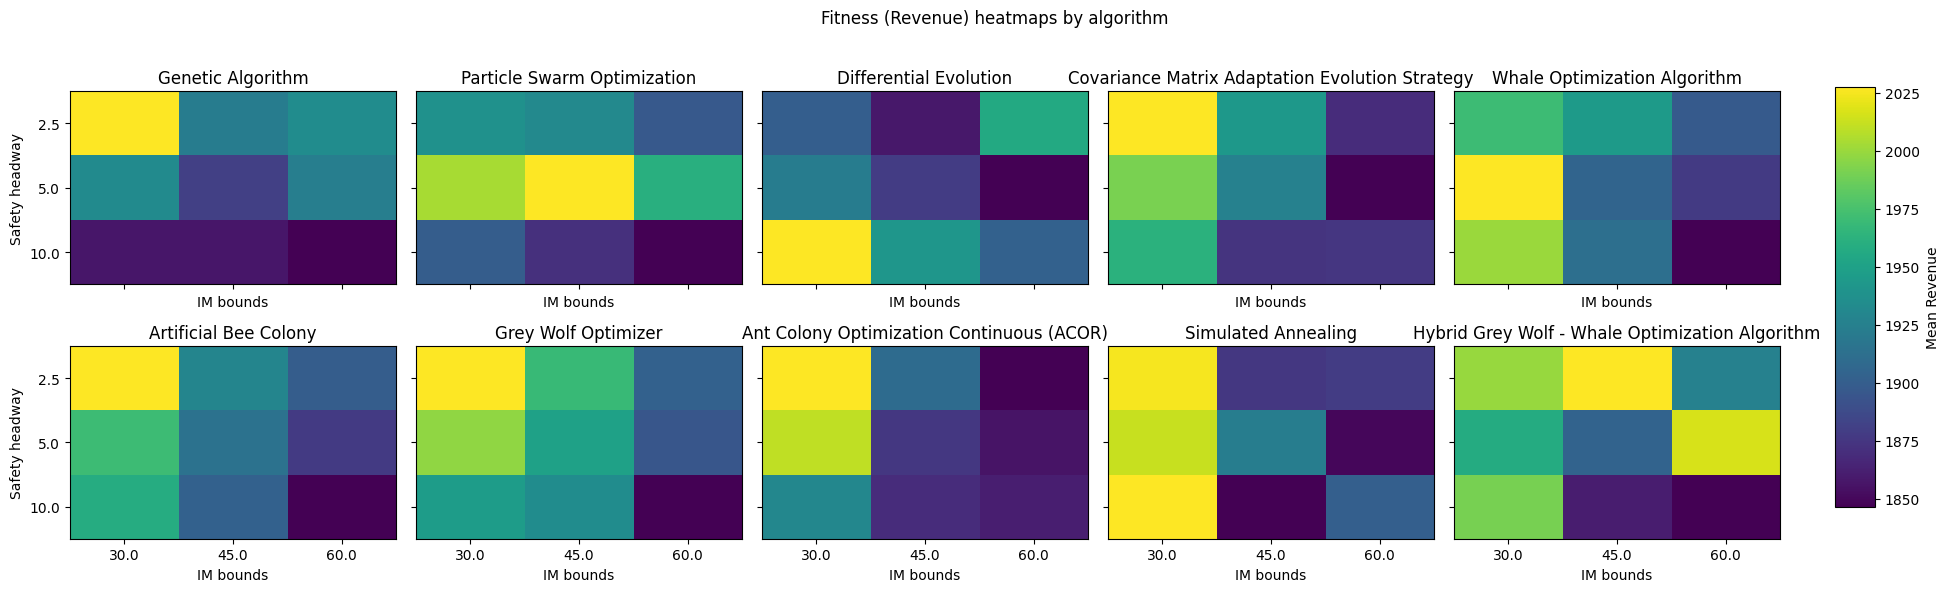

In [21]:
# 2) Heatmaps faceteados
import numpy as np
import matplotlib.pyplot as plt

algs = df['Algorithm'].unique()
n = len(algs)
cols = 5
rows = int(np.ceil(n/cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for i, alg in enumerate(algs):
    ax = axes[i]
    sub = df[df['Algorithm']==alg]
    pivot = sub.groupby(['safety','infra'], observed=True)['Revenue'].mean().unstack()

    # Dibuja la matriz de calor
    cax = ax.imshow(pivot.values, aspect='auto')
    ax.set_title(alg)

    # Ticks y etiquetas
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)

    # Sólo en la última fila ponemos la etiqueta del eje X
    row = i // cols
    col = i % cols

    ax.set_xlabel('IM bounds')
    # Sólo en la primera columna ponemos la etiqueta del eje Y
    if col == 0:
        ax.set_ylabel('Safety headway')

# Oculta los ejes sobrantes si n < rows*cols
for j in range(n, rows*cols):
    fig.delaxes(axes[j])

# Barra de color común
fig.subplots_adjust(right=0.9, hspace=0.5)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(cax, cax=cbar_ax, label='Mean Revenue')

plt.suptitle('Fitness (Revenue) heatmaps by algorithm')
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
# Save figure as pdf
fig.savefig('../reports/sensitivity_analysis/figures/heatmaps_algorithm.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [22]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrlllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU5 & RU3 & RU2 \\\\\n\\midrule\n24 & Genetic Algorithm & 5 & 6226.820000 & 82.170000 & 26 & 423.000000 & 108.000000 & 40.0 % & 58.33 % & 58.33 % & 61.54 % & 25.0 % \\\\\n22 & Genetic Algorithm & 3 & 6211.510000 & 80.620000 & 28 & 380.000000 & 140.000000 & 40.0 % & 66.67 % & 66.67 % & 53.85 % & 37.5 % \\\\\n20 & Genetic Algorithm & 1 & 6036.680000 & 80.430000 & 28 & 543.000000 & 130.000000 & 40.0 % & 66.67 % & 58.33 % & 61.54 % & 37.5 % \\\\\n23 & Genetic Algorithm & 4 & 6019.800000 & 83.630000 & 26 & 289.000000 & 143.000000 & 60.0 % & 58.33 % & 58.33 % & 53.85 % & 25.0 % \\\\\n21 & Genetic Algorithm & 2 & 5984.390000 & 80.730000 & 28 & 387.000000 & 170.000000 & 60.0 % & 58.33 % & 58.33 % & 69.23 % & 25.0 % \\\\\n48 & Whale Optimization Algorithm & 4 & 5249.330000 & 78.040000 & 23 & 775.000000 & 76.000000 & 40.0 % & 50.0 % 

In [23]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 2.2644 s.
	Execution Time (by run) - Mean: 0.4529 s. - Std: 0.0083 s.
	Revenue - Mean: 3941.9094 - Std: 133.3718
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 8.0624 s.
	Execution Time (by run) - Mean: 1.6125 s. - Std: 0.0238 s.
	Revenue - Mean: 3959.023 - Std: 219.2693
	Scheduled Trains - Mean: 21.0 - Std: 2.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 12.6699 s.
	Execution Time (by run) - Mean: 2.534 s. - Std: 0.3328 s.
	Revenue - Mean: 3486.9234 - Std: 244.3291
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 3.9

In [42]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby(['safety_headway', 'im_bound'])
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')

        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)

        result = {
            'Algorithm': algo_name,
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }

        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,Algorithm,Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,"(2.5, 45.0)",3319.03,178.73,18,1
1,"(2.5, 60.0)",3317.53,129.24,17,0
2,"(5.0, 60.0)",3270.66,84.45,17,1
3,"(5.0, 45.0)",3249.90,117.12,17,1
4,"(2.5, 30.0)",3226.28,56.20,18,0
5,"(5.0, 30.0)",3156.06,86.07,17,1
6,"(10.0, 60.0)",2981.71,174.13,16,1
7,"(10.0, 45.0)",2971.14,152.96,15,2
8,"(10.0, 30.0)",2915.33,121.51,15,1


In [40]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,safety_headway,im_bound
0,1,Genetic Algorithm,0,2502.910588,0.229565,"[False, True, False, True, True, True, True, F...","[1086, 1109, 1148, 858, 970, 1046, 898, 805, 9...",7.341053,0.000000,100.000000,10.0,30.0
1,1,Genetic Algorithm,1,2640.815661,0.280444,"[False, True, False, True, True, True, True, F...","[1060, 1109, 1140, 858, 975, 1049, 900, 827, 9...",6.463509,11.953924,88.046076,10.0,30.0
2,1,Genetic Algorithm,2,2730.387711,0.267000,"[False, True, False, True, True, False, True, ...","[1060, 1111, 1143, 858, 974, 1046, 900, 826, 9...",5.670526,22.755951,77.244049,10.0,30.0
3,1,Genetic Algorithm,3,2987.171566,0.258781,"[False, True, False, True, True, True, True, F...","[1062, 1109, 1140, 858, 974, 1049, 900, 826, 9...",5.079649,30.804894,69.195106,10.0,30.0
4,1,Genetic Algorithm,4,3329.851603,0.222542,"[False, True, False, True, True, True, True, F...","[1060, 1109, 1148, 847, 970, 1049, 886, 827, 9...",4.562105,37.854890,62.145110,10.0,30.0


In [25]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 81.520000 & 1.370000 & 6095.840000 & 114.280000 & 27 & 1 \\\\\n1 & Whale Optimization Algorithm & 78.280000 & 0.410000 & 4932.400000 & 251.400000 & 19 & 2 \\\\\n2 & Differential Evolution & 79.390000 & 0.910000 & 4911.590000 & 239.180000 & 24 & 1 \\\\\n3 & Particle Swarm Optimization & 79.960000 & 0.690000 & 4773.470000 & 347.690000 & 23 & 1 \\\\\n4 & Artificial Bee Colony & 159.610000 & 1.150000 & 3959.020000 & 219.270000 & 21 & 2 \\\\\n5 & Ant Colony Optimization Continuous (ACOR) & 44.800000 & 0.340000 & 3941.910000 & 133.370000 & 23 & 1 \\\\\n6 & Grey Wolf Optimizer & 78.270000 & 0.750000 & 3757.380000 & 156.010000 & 20 & 1 \\\\\n7 & Hybrid Grey Wolf - Whale Optimization Algorithm & 78.040000 & 0.670000 & 3557.140000 & 101.640000 & 2

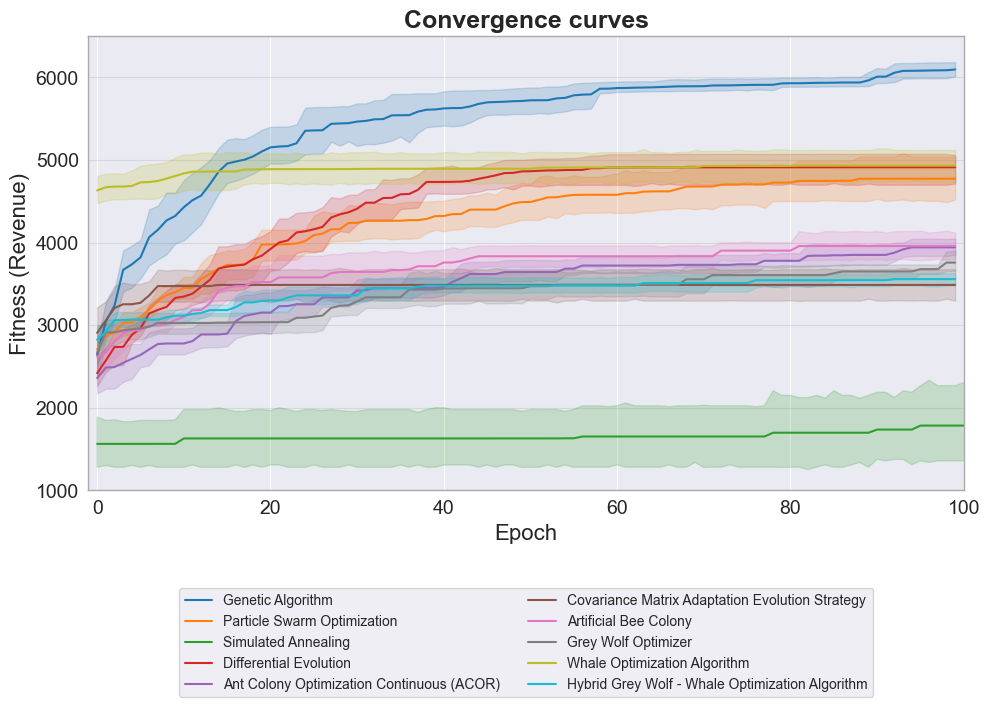

In [27]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1000,6500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed.pdf'),
              fig_size=(10, 9))

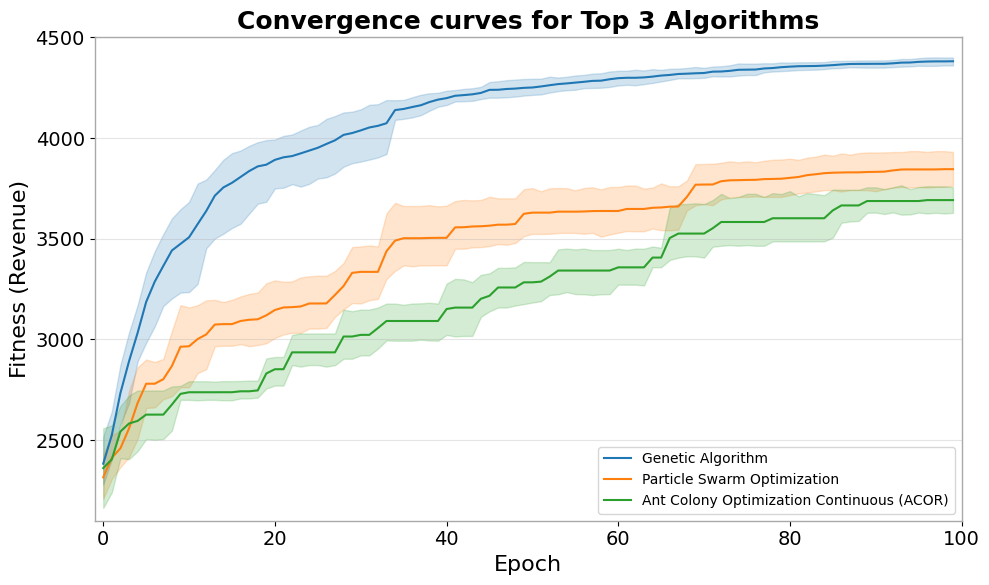

In [52]:
top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

sns_line_plot(df=df_history_top_3,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves for Top 3 Algorithms",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(2100,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed_top_3.pdf'),
              fig_size=(10, 7))

In [84]:
df_history.head()

,Run,Algo,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Genetic Algorithm,0,2459.878405,0.246457,"[False, True, False, True, True, True, True, F...","[1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...",3.209825,0.000000,100.000000
1,1,Genetic Algorithm,1,2460.308339,0.243454,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...",2.827368,11.915173,88.084827
2,1,Genetic Algorithm,2,2574.487027,0.243266,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...",2.692281,16.123743,83.876257
3,1,Genetic Algorithm,3,2926.528932,0.239713,"[False, True, False, True, True, True, True, F...","[1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...",2.463509,23.250984,76.749016
4,1,Genetic Algorithm,4,3015.854710,0.239389,"[False, True, False, True, True, False, True, ...","[1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...",2.223509,30.728028,69.271972


In [102]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [20]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

[2607.780704168451,
 2703.21640230218,
 2911.444314465418,
 3103.973183542429,
 3220.667590931876,
 3365.2866137766955,
 3484.48609472132,
 3572.9260730745227,
 3640.073782168727,
 3669.5832622522,
 3705.136185446733,
 3794.5588181089274,
 3839.792800278671,
 3863.719004722367,
 3906.153305799562,
 3960.321202641717,
 3960.321202641717,
 4005.737551227856,
 4021.701509559909,
 4036.1238629427503,
 4036.374965155991,
 4037.255279037032,
 4047.601165890613,
 4072.3073805030704,
 4100.486496755227,
 4102.769254199621,
 4125.723121565449,
 4149.827532752619,
 4172.08849602329,
 4172.08849602329,
 4183.598501918915,
 4194.791579881078,
 4197.818016088964,
 4226.226027636936,
 4226.226027636936,
 4226.226027636936,
 4228.039611525929,
 4228.705076393186,
 4240.677771701874,
 4240.677771701874,
 4253.38097286305,
 4253.38097286305,
 4253.38097286305,
 4256.742944859372,
 4261.969159858364,
 4309.924958575424,
 4310.657875981058,
 4323.559176282795,
 4323.559176282795,
 4323.559176282795,
 432

In [21]:
print(len(algo_vals))

100


In [26]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

[2121.942526311217,
 2126.1450191909216,
 2153.200797898652,
 2172.1936191864675,
 2174.216600940857,
 2195.3208372725726,
 2204.6153864302687,
 2223.3679354022047,
 2225.390917156595,
 2244.3606160414943,
 2244.3606160414943,
 2247.4535123926985,
 2270.379052946466,
 2270.492084344696,
 2274.816620508482,
 2298.572311796074,
 2316.002237825652,
 2316.002237825652,
 2316.002237825652,
 2320.215221955512,
 2325.565748811522,
 2332.3340863078133,
 2339.717662177076,
 2345.9459463700828,
 2349.005632648977,
 2583.144820693363,
 2590.85225513937,
 2592.3896854296745,
 2596.703525330692,
 2596.703525330692,
 2599.58923714303,
 2623.8452559548505,
 2623.8452559548505,
 2628.9170645467857,
 2630.988554963445,
 2635.5254248523797,
 2649.8720529088614,
 2655.7557863545885,
 2659.9093170072138,
 2660.827594946524,
 2668.118106647075,
 2668.118106647075,
 2671.661031899009,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743

In [27]:
print(len(algo_vals))

100


In [28]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [29]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      3.0   
Covariance Matrix Adaptation Evolution Strategy               39.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                 239.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        0.0   
Particle Swarm Optimization                          

In [30]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

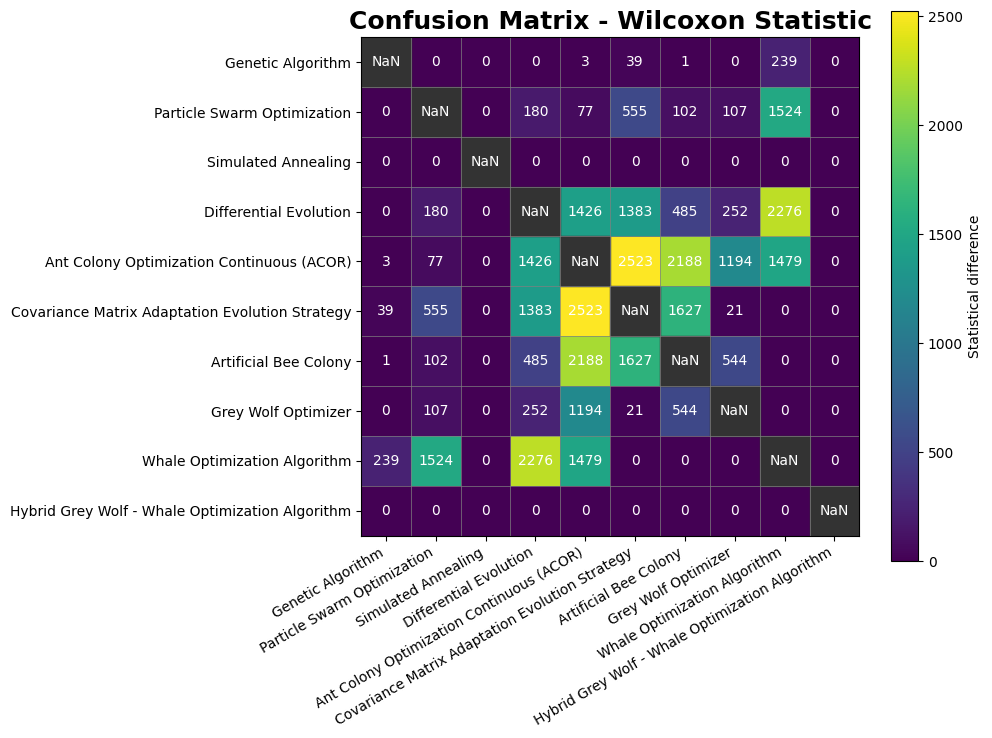

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

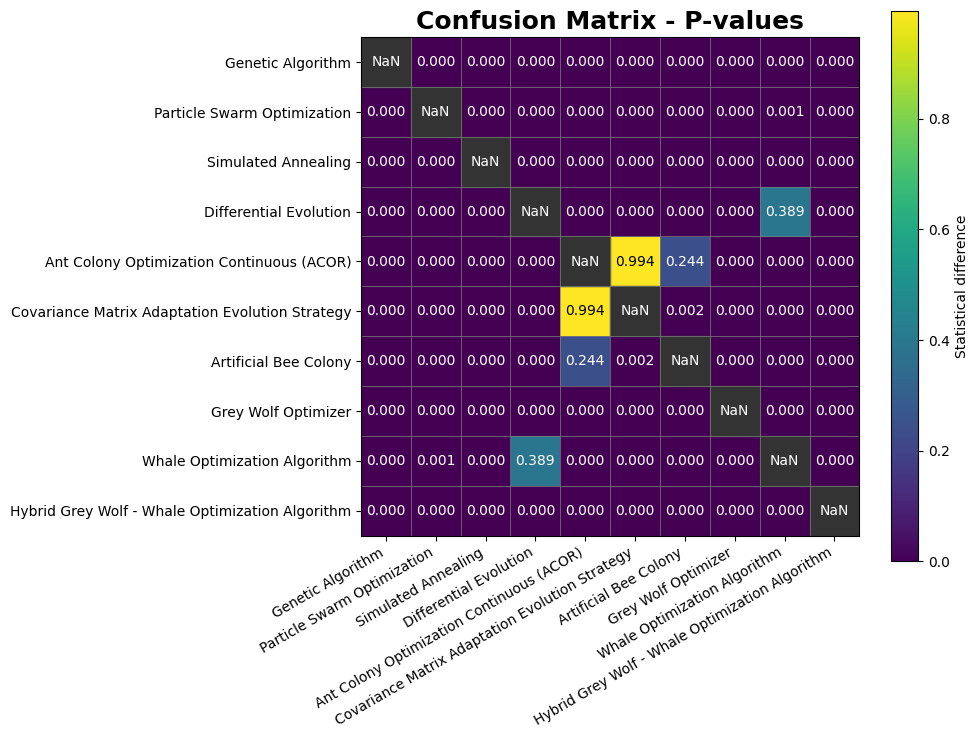

In [33]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

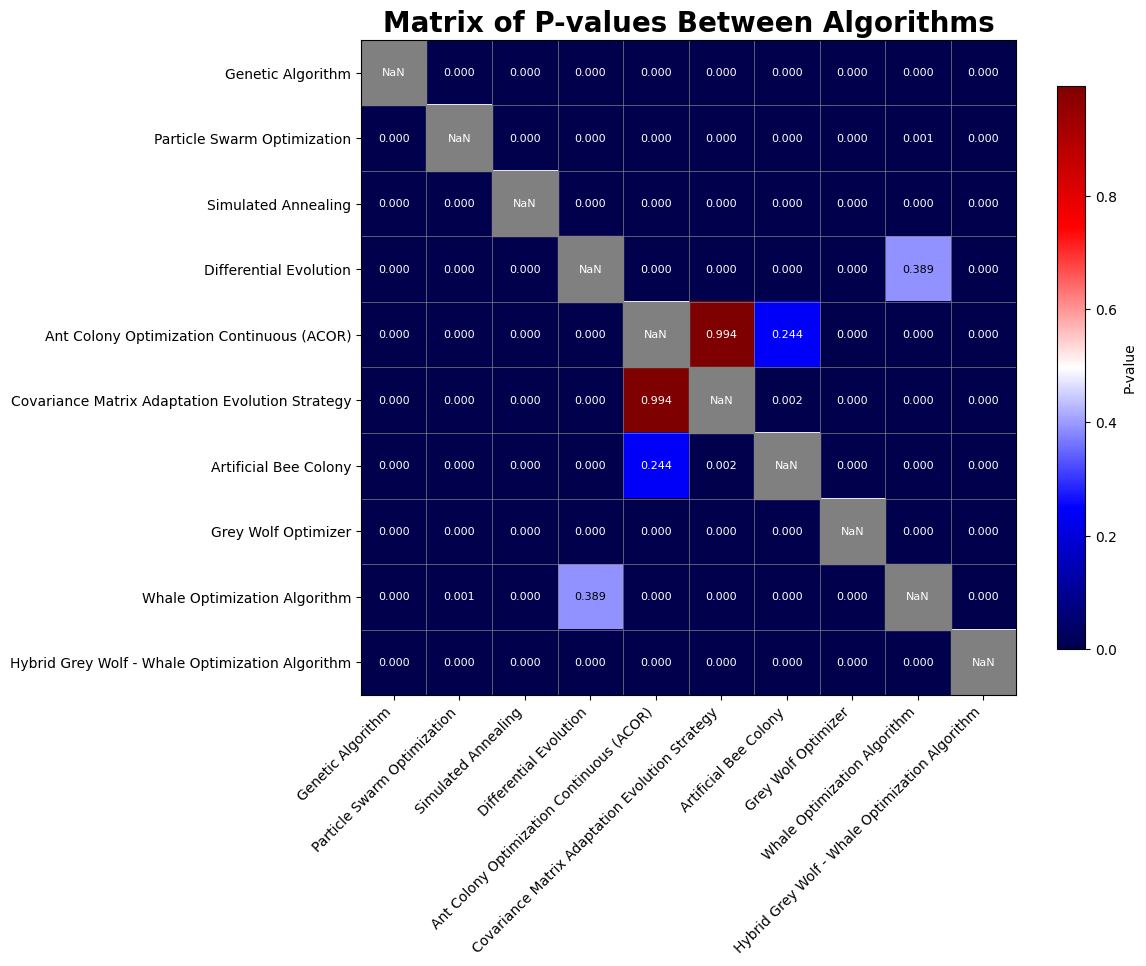

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [37]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 5
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1065. 1112. 1142.  873.  972. 1046.  907.  828.  913. 1355.  731.  130.
  210.  271.  479.  531.  630.  693.  930.  748.  177.  399.  463.  506.
  939.  968. 1038. 1094. 1132. 1161. 1188. 1253. 1309. 1345.  422.  466.
  503.  278.  336.  374.  528.  570. 1070. 1190. 1249. 1288.  559.  613.
  649. 1241.  462.  525.  567. 1276.  898.  998. 1060.], Discrete: [False  True False  True  True  True  True False  True False  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True]


In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [26]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


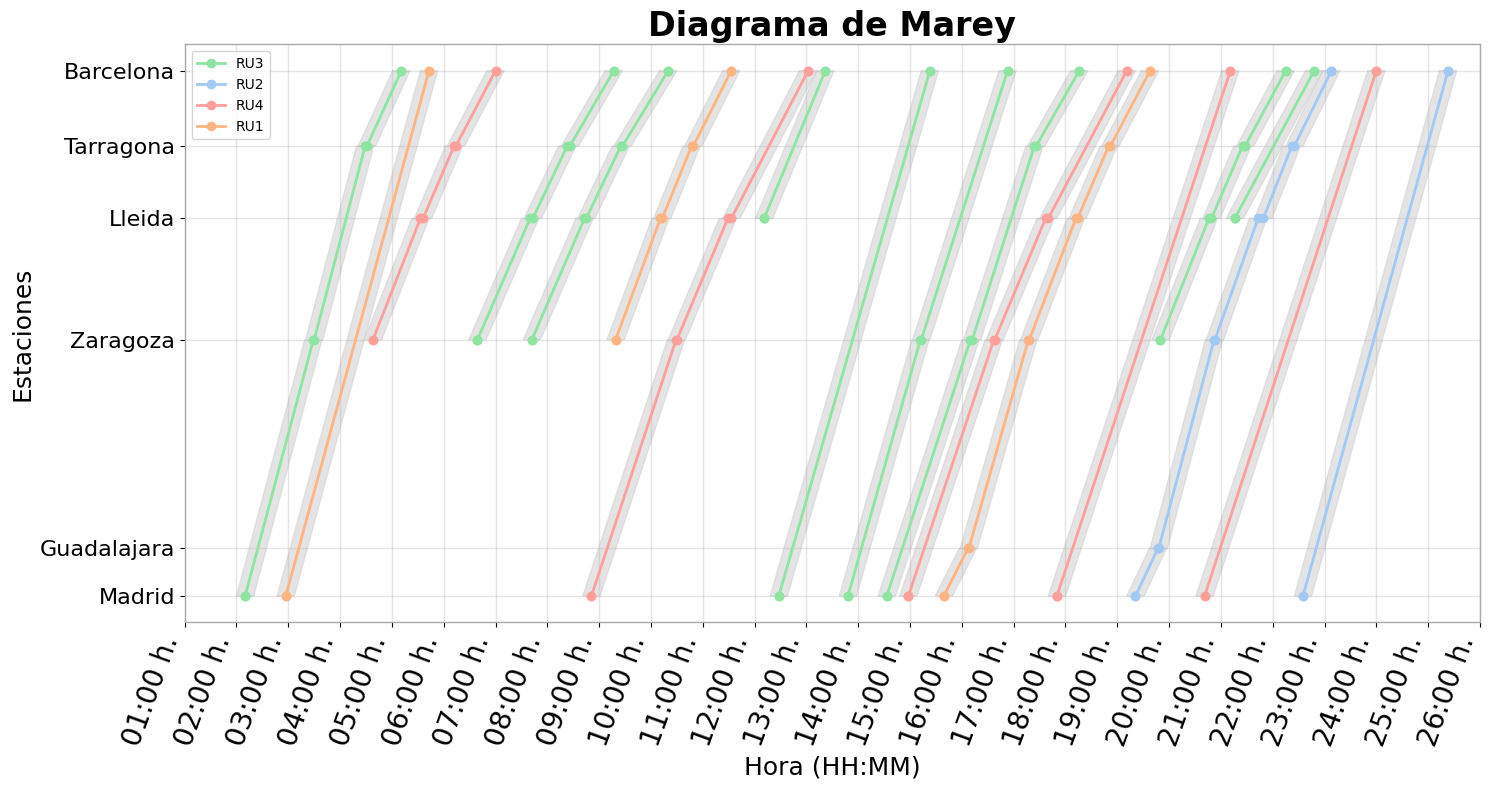

In [27]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat